In [48]:
#LIBRARIES
import urllib
import pandas as pd
import requests
from bs4 import BeautifulSoup
from IPython.display import display
import os
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import syllables
from nltk.corpus import stopwords
import string
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
#DATA CRAWLING

def get_article_text(url):
    res = requests.get(url)
    if res.status_code == 200:
        html_page = res.content
        soup = BeautifulSoup(html_page, features='html.parser')
        article_element = soup.find("article")
        if article_element:
            article_text = ' '.join(article_element.stripped_strings)
            return article_text
        else:
            print("Article element not found.")
            return None
    else:
        print(f"Failed to retrieve the page. Status code: {res.status_code}")
        return None

def url_to_dataframe(url):
    article_text = get_article_text(url)
    if article_text:
        df = pd.DataFrame(data={'Article': [article_text]})
        return df
    else:
        return pd.DataFrame()
url = "https://insights.blackcoffer.com/how-will-covid-19-affect-the-world-of-work-2/"
df = url_to_dataframe(url)


In [50]:


display(df)




,Article
0,Home Blackcoffer How will COVID-19 affect the ...


In [51]:
#Sentimental Analysis

nltk.download('punkt')
stopwords_directory = '/root/src/NLP-Based-Article-Analyzer/StopWords'
master_dictionary_directory = '/root/src/NLP-Based-Article-Analyzer/MasterDictionary'
def read_stopwords_from_directory(directory):
    stopword_strings = []
    encodings = ['utf-8', 'latin-1', 'cp1252']  # List of possible encodings
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        for encoding in encodings:
            try:
                with open(filepath, 'r', encoding=encoding) as file:
                    stopword_strings.append(file.read())
                break  
            except UnicodeDecodeError:
                continue  # Try the next encoding
    return stopword_strings
stopword_strings = read_stopwords_from_directory(stopwords_directory)
def calculate_sentiment_scores(dataframe):
    link_pattern = re.compile(r'https?://[^\s]+|www\.[^\s]+')
    final_stopword_list = []
    for stopword_string in stopword_strings:
        stopword_string_lower = stopword_string.lower()
        stopwords_from_string = stopword_string_lower.split()
        filtered_words = [word for word in stopwords_from_string if not link_pattern.match(word) and not re.match(r'\W+', word)]
        final_stopword_list.extend(filtered_words)
    final_stopword_list = list(set(final_stopword_list))
    def remove_stopwords(text):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in final_stopword_list]
        return ' '.join(filtered_words)
    dataframe['Cleaned_Article'] = dataframe['Article'].apply(lambda x: remove_stopwords(x))
    with open(os.path.join(master_dictionary_directory, 'positive-words.txt'), 'r', encoding='utf-8') as file:
        positive_word_list = re.findall(r'\b\w+\b', file.read())
    
    with open(os.path.join(master_dictionary_directory, 'negative-words.txt'), 'r', encoding='latin-1') as file:
        negative_word_list = re.findall(r'\b\w+\b', file.read())
    df_words = word_tokenize(dataframe['Cleaned_Article'].iloc[0])
    found_positive_word_list = [word for word in df_words if word in positive_word_list]
    found_negative_word_list = [word for word in df_words if word in negative_word_list]
    positive_score = sum(1 for word in df_words if word in found_positive_word_list)
    negative_score = sum(-1 for word in df_words if word in found_negative_word_list) * -1
    polarity_score = (positive_score - negative_score) / ((positive_score + negative_score) + 0.000001)
    subjectivity_score = (positive_score + negative_score) / (len(df_words) + 0.000001)

    return {
        'Positive Score': positive_score,
        'Negative Score': negative_score,
        'Polarity Score': polarity_score,
        'Subjectivity Score': subjectivity_score
    }
df = url_to_dataframe(url)
result = calculate_sentiment_scores(df)
for key, value in result.items():
    print(f"{key}: {value}")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Positive Score: 49
Negative Score: 63
Polarity Score: -0.12499999888392858
Subjectivity Score: 0.13429256578621995


In [52]:
#Analysis of Readability
nltk.download('punkt')

def calculate_sentence_complexity_metrics(dataframe):
    cleaned_articles = dataframe['Article'].apply(str) 
    sentences = cleaned_articles.apply(sent_tokenize)
    words = cleaned_articles.apply(word_tokenize)
    average_sentence_length = words.apply(len) / sentences.apply(len)

    complex_words = words.apply(lambda w: [word for word in w if len(word) > 6]) 
    percentage_complex_words = complex_words.apply(len) / words.apply(len)
    fog_index = 0.4 * (average_sentence_length + percentage_complex_words)

    return {
        'Average Sentence Length': average_sentence_length.mean(),
        'Percentage of Complex Words': percentage_complex_words.mean(),
        'Fog Index': fog_index.mean()
    }

sentence_complexity_metrics_result = calculate_sentence_complexity_metrics(df)

for key, value in sentence_complexity_metrics_result.items():
    print(f"{key}: {value}")

Average Sentence Length: 40.6
Percentage of Complex Words: 0.29064039408866993
Fog Index: 16.356256157635467


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
#Average Number of Words Per Sentence
nltk.download('punkt')

def calculate_average_words_per_sentence(dataframe):
    sentences = [sent_tokenize(text) for text in dataframe['Article']]
    words = [word_tokenize(text) for text in dataframe['Article']]

    average_words_per_sentence = len(words[0]) /len(sentences[0])
    return average_words_per_sentence
average_words_per_sentence_result = calculate_average_words_per_sentence(df)

print("Average Number of Words Per Sentence:", average_words_per_sentence_result)

Average Number of Words Per Sentence: 40.6


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [54]:
#Complex Word Count

def calculate_complex_word_count(dataframe):

    words = [word_tokenize(text) for text in dataframe['Article']]

    flattened_words = [word for sublist in words for word in sublist]

    complex_words_count = sum(1 for word in flattened_words if syllables.estimate(word) > 2)

    return complex_words_count


complex_words_count_result = calculate_complex_word_count(df)

print("Complex Word Count:", complex_words_count_result)


Complex Word Count: 302


In [55]:
# Word Count

nltk.download('punkt')
nltk.download('stopwords')

def calculate_total_cleaned_words(dataframe):
    words = [word_tokenize(text) for text in dataframe['Article']]
    flattened_words = [word for sublist in words for word in sublist]
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in flattened_words if word.lower() not in stop_words and word.lower() not in string.punctuation]
    filtered_words = [''.join(char for char in word if char.isalnum()) for word in filtered_words if any(char.isalnum() for char in word)]
    total_cleaned_words = len(filtered_words)

    return total_cleaned_words
total_cleaned_words_result = calculate_total_cleaned_words(df)
print("Total Cleaned Words:", total_cleaned_words_result)

Total Cleaned Words: 765


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
#Syllable Count Per Word
nltk.download('punkt')
def count_syllables(word):
    vowels = "aeiouy"
    count = 0
    prev_char = ''
    for char in word:
        char_lower = char.lower()
        if char_lower in vowels and prev_char not in vowels:
            count += 1
        prev_char = char_lower
    if word.endswith(("es", "ed")) and count > 1:
        count -= 1  
    return max(count, 1)  

def calculate_syllable_counts(dataframe):
    words = [word_tokenize(text) for text in dataframe['Article']]
    flattened_words = [word for sublist in words for word in sublist]

    syllables_per_word = [count_syllables(word) for word in flattened_words]

    total_syllables = sum(syllables_per_word)
    average_syllables_per_word = total_syllables / len(flattened_words)


    return syllables_per_word, total_syllables, average_syllables_per_word

syllables_per_word, total_syllables, average_syllables_per_word = calculate_syllable_counts(df)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [57]:
#Personal Pronouns
def count_personal_pronouns(dataframe):

    personal_pronouns_pattern = re.compile(r'\b(?:I|we|my|ours|us)\b', flags=re.IGNORECASE)

    personal_pronouns_matches = personal_pronouns_pattern.findall(dataframe['Article'].iloc[0])
    personal_pronouns_count = len(personal_pronouns_matches)

    return personal_pronouns_count
personal_pronouns_count_result = count_personal_pronouns(df)

print("Personal Pronouns Count:", personal_pronouns_count_result)

Personal Pronouns Count: 5


In [58]:
#Average Word Length
nltk.download('punkt')

def calculate_average_word_length(dataframe):
    words = [word_tokenize(text) for text in dataframe['Article']]
    flattened_words = [word for sublist in words for word in sublist]
    total_characters = sum(len(word) for word in flattened_words)
    total_words = len(flattened_words)
    average_word_length = total_characters / total_words if total_words > 0 else 0

    return average_word_length
average_word_length_result = calculate_average_word_length(df)

print("Average Word Length:", average_word_length_result)


Average Word Length: 4.836030964109782


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [59]:


input_file_path = '/root/src/NLP-Based-Article-Analyzer/Input.csv'
output_file_path = '/root/src/NLP-Based-Article-Analyzer/Output Data Structure.csv'

input_df = pd.read_csv(input_file_path)

output_df = pd.read_csv(output_file_path)

input_df.head(), output_df.head()


(       URL_ID                                                URL
 0  bctech2011  https://insights.blackcoffer.com/ml-and-ai-bas...
 1  bctech2012  https://insights.blackcoffer.com/streamlined-i...
 2  bctech2013  https://insights.blackcoffer.com/efficient-dat...
 3  bctech2014  https://insights.blackcoffer.com/effective-man...
 4  bctech2015  https://insights.blackcoffer.com/streamlined-t...,
        URL_ID                                                URL  \
 0  bctech2011  https://insights.blackcoffer.com/ml-and-ai-bas...   
 1  bctech2012  https://insights.blackcoffer.com/streamlined-i...   
 2  bctech2013  https://insights.blackcoffer.com/efficient-dat...   
 3  bctech2014  https://insights.blackcoffer.com/effective-man...   
 4  bctech2015  https://insights.blackcoffer.com/streamlined-t...   
 
    POSITIVE SCORE  NEGATIVE SCORE  POLARITY SCORE  SUBJECTIVITY SCORE  \
 0           108.0              46        0.402597            0.063244   
 1            18.0               5     

In [60]:

n=0
for index, row in input_df.iterrows():
    url_id = row['URL_ID']
    url = row['URL']
    df = url_to_dataframe(url)

    sentiment_scores = calculate_sentiment_scores(df)

    sentence_complexity_metrics = calculate_sentence_complexity_metrics(df)
    avg_words_per_sentence = calculate_average_words_per_sentence(df)
    complex_word_count = calculate_complex_word_count(df)
    total_cleaned_words = calculate_total_cleaned_words(df)
    syllables_per_word_result, total_syllables_result, average_syllables_per_word_result = calculate_syllable_counts(df)
    personal_pronouns_count = count_personal_pronouns(df)
    avg_word_length = calculate_average_word_length(df)

    output_df.at[index, 'POSITIVE SCORE'] = sentiment_scores['Positive Score']
    output_df.at[index, 'NEGATIVE SCORE'] = sentiment_scores['Negative Score']
    output_df.at[index, 'POLARITY SCORE'] = sentiment_scores['Polarity Score']
    output_df.at[index, 'SUBJECTIVITY SCORE'] = sentiment_scores['Subjectivity Score']

    output_df.at[index, 'AVG SENTENCE LENGTH'] = sentence_complexity_metrics['Average Sentence Length']
    output_df.at[index, 'PERCENTAGE OF COMPLEX WORDS'] = sentence_complexity_metrics['Percentage of Complex Words']
    output_df.at[index, 'FOG INDEX'] = sentence_complexity_metrics['Fog Index']
    output_df.at[index, 'AVG NUMBER OF WORDS PER SENTENCE'] = avg_words_per_sentence
    output_df.at[index, 'COMPLEX WORD COUNT'] = complex_word_count
    output_df.at[index, 'WORD COUNT'] = total_cleaned_words
    output_df.at[index, 'SYLLABLE PER WORD'] = average_syllables_per_word_result
    output_df.at[index, 'PERSONAL PRONOUNS'] = personal_pronouns_count
    output_df.at[index, 'AVG WORD LENGTH'] = avg_word_length
    n=n+1
    print(f"{n}.URL DECODING........")

print("Parameter Updated in Dataframe Sucessfully....")


1.URL DECODING........
2.URL DECODING........
3.URL DECODING........
4.URL DECODING........
5.URL DECODING........
6.URL DECODING........
7.URL DECODING........
8.URL DECODING........
9.URL DECODING........
10.URL DECODING........
11.URL DECODING........
12.URL DECODING........
13.URL DECODING........
14.URL DECODING........
15.URL DECODING........
16.URL DECODING........
17.URL DECODING........
18.URL DECODING........
19.URL DECODING........
20.URL DECODING........
21.URL DECODING........
22.URL DECODING........
23.URL DECODING........
24.URL DECODING........
25.URL DECODING........
26.URL DECODING........
27.URL DECODING........
28.URL DECODING........
29.URL DECODING........
30.URL DECODING........
31.URL DECODING........
32.URL DECODING........
33.URL DECODING........
34.URL DECODING........
35.URL DECODING........
36.URL DECODING........
37.URL DECODING........
38.URL DECODING........
39.URL DECODING........
40.URL DECODING........
41.URL DECODING........
42.URL DECODING........
4

In [61]:
output_df

,URL_ID,URL,POSITIVE SCORE,NEGATIVE SCORE,POLARITY SCORE,SUBJECTIVITY SCORE,AVG SENTENCE LENGTH,PERCENTAGE OF COMPLEX WORDS,FOG INDEX,AVG NUMBER OF WORDS PER SENTENCE,COMPLEX WORD COUNT,WORD COUNT,SYLLABLE PER WORD,PERSONAL PRONOUNS,AVG WORD LENGTH
0,bctech2011,https://insights.blackcoffer.com/ml-and-ai-bas...,108.0,46,0.402597,0.063244,18.139665,0.427779,7.426978,18.139665,1115.0,2014.0,1.875269,2.0,5.544195
1,bctech2012,https://insights.blackcoffer.com/streamlined-i...,18.0,5,0.565217,0.038786,14.566038,0.424870,5.996363,14.566038,243.0,527.0,1.920984,1.0,5.915803
2,bctech2013,https://insights.blackcoffer.com/efficient-dat...,23.0,10,0.393939,0.047688,24.861111,0.388827,10.099975,24.861111,248.0,594.0,1.774302,1.0,5.541899
3,bctech2014,https://insights.blackcoffer.com/effective-man...,14.0,13,0.037037,0.046957,13.555556,0.418033,5.589435,13.555556,224.0,510.0,1.851093,1.0,5.729508
4,bctech2015,https://insights.blackcoffer.com/streamlined-t...,12.0,6,0.333333,0.028436,27.000000,0.365881,10.946352,27.000000,244.0,547.0,1.757576,2.0,5.262626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,bctech2153,https://insights.blackcoffer.com/population-an...,13.0,17,-0.133333,0.036946,31.102564,0.303380,12.562378,31.102564,284.0,775.0,1.674361,3.0,4.969497
143,bctech2154,https://insights.blackcoffer.com/google-lsa-ap...,18.0,24,-0.142857,0.037634,25.455882,0.282496,10.295351,25.455882,362.0,1042.0,1.648758,7.0,4.893703
144,bctech2155,https://insights.blackcoffer.com/healthcare-da...,9.0,13,-0.181818,0.061798,31.842105,0.241322,12.833371,31.842105,96.0,361.0,1.548760,14.0,4.720661
145,bctech2156,https://insights.blackcoffer.com/budget-sales-...,0.0,2,-1.000000,0.007143,119.333333,0.315642,47.859590,119.333333,87.0,253.0,1.715084,0.0,5.145251


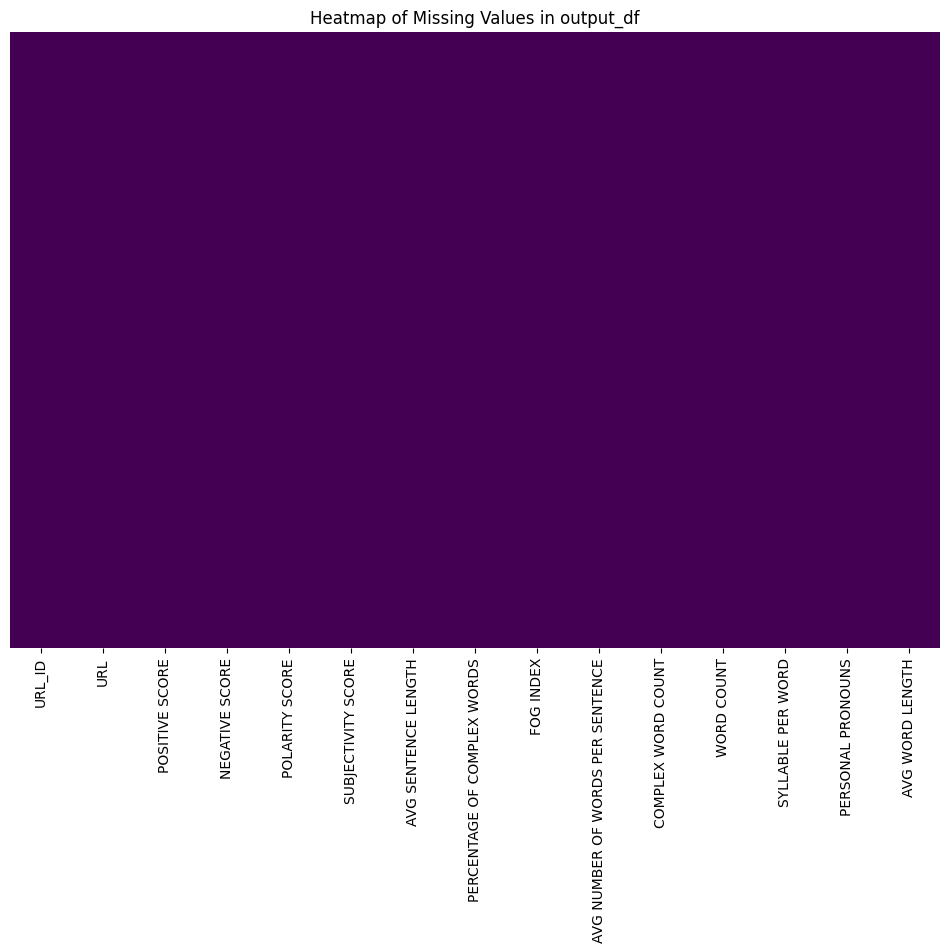

In [62]:
%matplotlib inline
# Check for null values and visualize
plt.figure(figsize=(12, 8))
sns.heatmap(output_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values in output_df')
plt.show()


In [63]:


# Assuming output_df is the updated DataFrame you want to save
output_file_path = '/root/src/NLP-Based-Article-Analyzer/Output Data Structure.csv'

# Save the DataFrame to a CSV file
output_df.to_csv(output_file_path, index=False)

print(f"Updated DataFrame saved to {output_file_path}")


Updated DataFrame saved to /root/src/NLP-Based-Article-Analyzer/Output Data Structure.csv
